In [1]:
import pandas as pd

# Load the selected dataset (Modify filename accordingly)
df = pd.read_csv(r"C:\Users\Shubham Dhiman\Untitled Folder 2\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")

# Display first few rows
print(df.head())


    Destination Port   Flow Duration   Total Fwd Packets  \
0              54865               3                   2   
1              55054             109                   1   
2              55055              52                   1   
3              46236              34                   1   
4              54863               3                   2   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        0                           12   
1                        1                            6   
2                        1                            6   
3                        1                            6   
4                        0                           12   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             0                       6   
1                             6                       6   
2                             6                       6   
3                             6                 

In [2]:
print(df.isnull().sum())  # Count of missing values per column


 Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
 Label                         0
Length: 79, dtype: int64


In [3]:
df.drop(["Timestamp", "Source IP", "Destination IP"], axis=1, inplace=True, errors="ignore")


In [4]:
print(df.dtypes)  # Display column data types


 Destination Port                int64
 Flow Duration                   int64
 Total Fwd Packets               int64
 Total Backward Packets          int64
Total Length of Fwd Packets      int64
                                ...   
Idle Mean                      float64
 Idle Std                      float64
 Idle Max                        int64
 Idle Min                        int64
 Label                          object
Length: 79, dtype: object


In [5]:
df = pd.get_dummies(df, drop_first=True)  # Convert categorical columns to numerical



In [6]:
from sklearn.preprocessing import StandardScaler



In [7]:
import numpy as np

# Check for NaN values
print("Missing values:\n", df.isnull().sum())

# Check for infinite values
print("Infinite values:\n", np.isinf(df).sum())

Missing values:
  Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
 Label_DDoS                    0
Length: 79, dtype: int64
Infinite values:
  Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
 Label_DDoS                    0
Length: 79, dtype: int64


In [8]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Convert infinite to NaN
df.fillna(df.median(), inplace=True)  # Replace NaN with median values


In [9]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)  # Should work now
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)  # Convert back to DataFrame

In [10]:
from sklearn.ensemble import IsolationForest

# Initialize the Isolation Forest model
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)


In [11]:
model.fit(df_scaled)


IsolationForest(contamination=0.05, random_state=42)

In [12]:
df['anomaly'] = model.predict(df_scaled)


In [13]:
print(df['anomaly'].value_counts())


anomaly
 1    214457
-1     11288
Name: count, dtype: int64


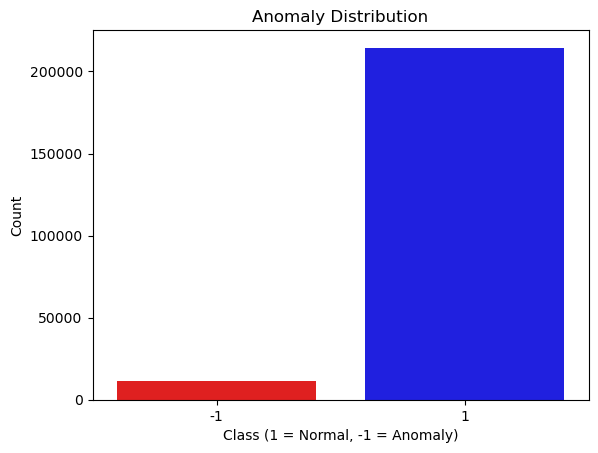

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count anomalies
sns.countplot(x=df['anomaly'], palette={1: "blue", -1: "red"})
plt.title("Anomaly Distribution")
plt.xlabel("Class (1 = Normal, -1 = Anomaly)")
plt.ylabel("Count")
plt.show()


In [15]:
total = len(df)
anomalies = df['anomaly'].value_counts()[-1]
percentage = (anomalies / total) * 100

print(f"Total records: {total}")
print(f"Anomalies detected: {anomalies} ({percentage:.2f}%)")


Total records: 225745
Anomalies detected: 11288 (5.00%)


In [16]:
from sklearn.model_selection import train_test_split

# Define X (features) and y (target labels)
X = df.drop(columns=['anomaly'])  # Features (excluding 'anomaly' column)
y = df['anomaly'].map({1: 0, -1: 1})  # Convert 'anomaly' column (1 = Normal, -1 = Anomaly → 0 = Normal, 1 = Anomaly)

# Now, split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
# Predict anomalies using the trained model
y_pred = model.predict(X_test)

# Print some predictions
print("Sample predictions:", y_pred[:10])  # Print first 10 predictions

# Convert predictions to binary (if required)
y_pred_binary = (y_pred == -1).astype(int)  # -1 = anomaly, 1 = normal (convert -1 to 1)
print("Binary predictions:", y_pred_binary[:10])  # Print first 10 converted predictions


Sample predictions: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Binary predictions: [1 1 1 1 1 1 1 1 1 1]


In [18]:
import numpy as np

# Count detected anomalies
anomalies_detected = np.sum(y_pred == -1)
total_test_samples = len(y_pred)

print(f"Total test samples: {total_test_samples}")
print(f"Anomalies detected in test set: {anomalies_detected} ({(anomalies_detected/total_test_samples) * 100:.2f}%)")


Total test samples: 45149
Anomalies detected in test set: 45149 (100.00%)


In [19]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Print Accuracy Score
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy:.4f}")

# Print Classification Report
print(classification_report(y_test, y_pred_binary))

# Print Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:\n", cm)


Accuracy: 0.0495
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     42916
           1       0.05      1.00      0.09      2233

    accuracy                           0.05     45149
   macro avg       0.02      0.50      0.05     45149
weighted avg       0.00      0.05      0.00     45149

Confusion Matrix:
 [[    0 42916]
 [    0  2233]]


C:\Users\Shubham Dhiman\py\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shubham Dhiman\py\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shubham Dhiman\py\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


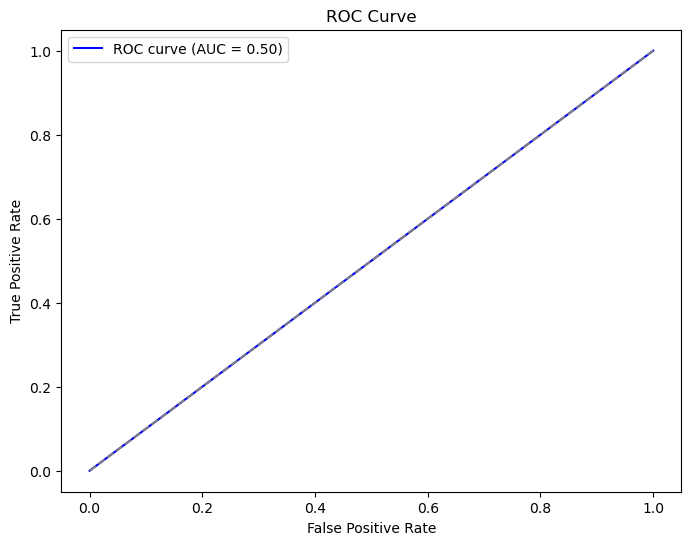

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


Total records: 225745
Anomalies detected: 11288 (5.00%)


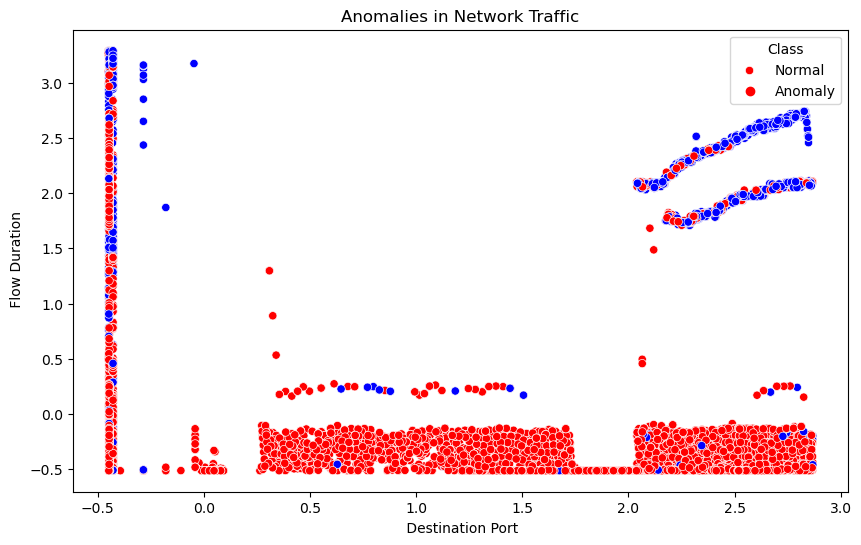

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv(r"C:\Users\Shubham Dhiman\Untitled Folder 2\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")

# Drop unnecessary columns
df.drop(["Timestamp", "Source IP", "Destination IP"], axis=1, inplace=True, errors="ignore")

# Convert categorical variables to numerical
df = pd.get_dummies(df, drop_first=True)

# Handle missing and infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.median(), inplace=True)

# Normalize the dataset
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

# Initialize and fit the Isolation Forest model
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
model.fit(df_scaled)

df['anomaly'] = model.predict(df_scaled)

total = len(df)
anomalies = (df['anomaly'] == -1).sum()
percentage = (anomalies / total) * 100

print(f"Total records: {total}")
print(f"Anomalies detected: {anomalies} ({percentage:.2f}%)")

# Prepare data for training/testing
X = df_scaled
y = (df['anomaly'] == -1).astype(int)  # Convert anomaly labels to binary (1 = Anomaly, 0 = Normal)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an Isolation Forest on training data
model.fit(X_train)

y_pred = model.predict(X_test)
y_pred_binary = (y_pred == -1).astype(int)

# Convert to DataFrame for visualization
feature_names = df.columns[:-1]
df_test = pd.DataFrame(X_test, columns=feature_names)
df_test['Actual'] = y_test
df_test['Predicted'] = y_pred_binary

# Visualization with corrected color mapping
palette = {0: "red", 1: "blue"}  # Normal = Green, Anomaly = Red

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_test,
    x=df_test.columns[0],  # Use first feature for X-axis
    y=df_test.columns[1],  # Use second feature for Y-axis
    hue=df_test['Predicted'],  # Use Predicted values for coloring
    palette=palette
)

plt.title('Anomalies in Network Traffic')
plt.xlabel(df_test.columns[0])
plt.ylabel(df_test.columns[1])
plt.legend(title='Class', labels=['Normal', 'Anomaly'])
plt.show()
